In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [181]:
dt = 0.1

# Phase I

In [182]:
def phase1_spatial_growth(N, layer_bounds, layer_densities, local_conn_per_node, alpha_init):
    """
    Phase 1: create a purely local spatial network with high clustering.

    N: total number of neurons
    layer_bounds: list of region boundaries or cluster definitions (n_layers, 3, 2)
    layer_densities: relative densities of neurons in each layer (n_layers,)
    local_conn_per_node: max local out-degree per neuron
    alpha_init: initial distance scale parameter
    """

    # Normalized densities
    layer_densities = np.array(layer_densities)
    layer_densities /= np.sum(layer_densities)

    # Neurons per layer
    neurons_per_layer = (layer_densities * N).astype(int)

    coords_layers = []

    for i, (layer_bound, density) in enumerate(zip(layer_bounds, neurons_per_layer)):
        # 1.1. Sample 3D coordinates uniformly within the layer's bounds
        coords = np.random.uniform(layer_bound[:, 0], layer_bound[:, 1], size=(density, 3))
        coords_layers.append(coords)

    # Concatenate all coordinates
    coords = np.concatenate(coords_layers, axis=0)

    # Build KDTree for fast neighbor queries
    tree = cKDTree(coords)

    # Initialize an empty directed graph
    G = nx.DiGraph()
    G.add_nodes_from(range(N))

    # For each neuron, select its local_conn_per_node nearest neighbors
    #      and create edges if distance‐penalized random check passes
    # (We use a high alpha_init so only very short connections form)
    for i in range(N):
        # Find, e.g., 2×local_conn nearest neighbors (so we have a buffer for rejection)
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        # Skip the first neighbor (itself, dists[0]==0)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        for j, dist_ij in candidates:
            if num_added >= local_conn_per_node: 
                break
            # Connection probability ∝ exp(−alpha_init * dist_ij)
            p = np.exp(-alpha_init * dist_ij)
            if np.random.rand() < p:
                G.add_edge(i, int(j), distance=dist_ij)
                num_added += 1
        # If fewer than local_conn_per_node edges were formed, that's fine; biological variability.
    return G, coords, neurons_per_layer


In [183]:
N = 50
out_max = 20
alpha_init = 12.0

n_layers = 2
layer_boundaries = np.zeros((n_layers, 3, 2))
layer_boundaries[:,:, 1] = 1.0  # Begin by making all layers cover the full volume
# Make x,y go to 0.5
layer_boundaries[:, 0, 1] = 0.5  # x_max
layer_boundaries[:, 1, 1] = 0.5  # y_max
# Differentiate layers along the z-axis
# Define bottom layer
layer_boundaries[0, 2, 1] = 0.35  # z_min
# Top layer between 0.6 and 1.0
layer_boundaries[1, 2, 0] = 0.65  # z_max

# These are relative layer densities
layer_densities = np.ones(n_layers)

G_directed, coords, neurons_per_layer = phase1_spatial_growth(N, layer_boundaries, layer_densities , out_max, alpha_init)

## Small world?

In [184]:
G_undirected = G_directed.to_undirected()
# Prune unconnected nodes
G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))
# Make it so that graph is connected
if not nx.is_connected(G_undirected):
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_undirected = G_undirected.subgraph(largest_cc).copy()

# print(smallworld.sigma(G_undirected, 50, 5))
# print(smallworld.omega(G_undirected, 5, 10))

Nodes: 50, Edges: 65
In-degree dist: Counter({1: 18, 0: 13, 2: 13, 3: 4, 4: 1, 5: 1})
Out-degree dist: Counter({1: 22, 0: 11, 2: 10, 3: 5, 4: 2})
Total-degree dist: Counter({2: 15, 3: 10, 0: 6, 1: 6, 4: 6, 6: 5, 5: 2})


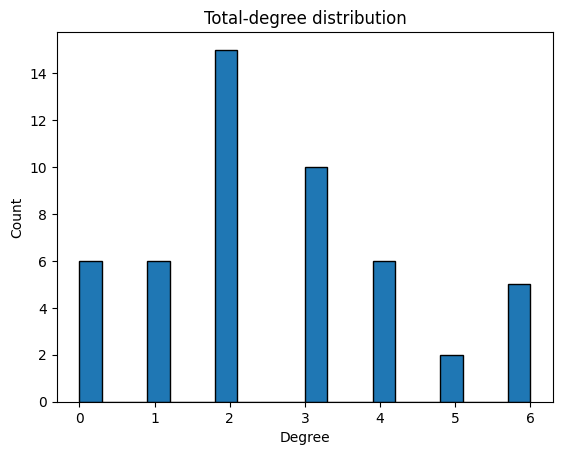

In [185]:
# --- 1. Basic stats
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G_directed.in_degree())
out_deg = dict(G_directed.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G_directed.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
plt.hist(list(tot_deg.values()), bins=20, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [186]:
html_file = "phase1.html" 
notebook: bool = True
colour_scheme: str = "layer" 
node_size_scale: float = 2.0
coord_scale: float = 1000.0

try:
    from pyvis.network import Network
except ImportError:
    raise ImportError("pyvis not found - install with `pip install pyvis`")

net = Network(height="750px", width="100%", directed=True,
            notebook=notebook, bgcolor="#ffffff", cdn_resources='remote')
net.repulsion()

# Compute each node's total degree
deg_in  = dict(G_directed.in_degree())
deg_out = dict(G_directed.out_degree())
total_deg = {n: deg_in.get(n, 0) + deg_out.get(n, 0) for n in G_directed.nodes}

# -------- nodes (with colours, tooltips, and dynamic sizes) ----------
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for n in G_directed.nodes:
    # Build hover title
    title = (
        f"Neuron {n}<br/>"
        f"InDegree: {deg_in.get(n, 0)}<br/>OutDegree: {deg_out.get(n, 0)}"
        f" Z: {coords[n][2] * coord_scale}"
    )

    # Size = (total_degree + 1) * node_size_scale
    size = (total_deg.get(n, 0) + 1) * node_size_scale

    net.add_node(n,
                label=str(n),
                title=title,
                size=size,
                # NOTE: coords[n] is a 3D coordinate, we use only x and z for 2D visualization
                x=coords[n][0] * coord_scale,  # Scale coords to fit in the network view
                y=coords[n][2] * coord_scale,
                fixed = True)  # Scale coords to fit in the network view)


# -------- edges ------------
for u, v, data in G_directed.edges(data=True):
    w = data.get("weight", None)
    syn_idx = data.get("synapse_index", None)
    dist = data.get("distance", None) * coord_scale  # anatomical distance
    # If distance is missing or zero, fallback to a small positive default
    length = float(dist) if (dist is not None and dist > 0.0) else 50.0

    # Edge thickness ∝ |weight|
    thickness = abs(w) if w is not None else 1.0

    hover_txt = []
    if syn_idx is not None:
        hover_txt.append(f"synapse_index = {syn_idx}")
    if w is not None:
        hover_txt.append(f"weight = {w:.3f}")
    if dist is not None:
        hover_txt.append(f"distance = {dist:.2f}")

    net.add_edge(
        u,
        v,
        value   = thickness * 0.1,         # edge thickness ∝ |weight|
        title   = "<br/>".join(hover_txt),
        # length  = length * 20              # rest‐length ≈ anatomical distance
    )

net.show(html_file)

phase1.html


# Phase II

In [ ]:
def phase2_spatial_growth(G, coords, neurons_per_layer, local_conn_per_node, 
                          flow, type_distribution, alpha_per_type, global_excit_hub_percentage=0.5):
    """
    Phase 2: differentiate neuron types, make sure all neurons have 1 in-degree and 1 out-degree,
    and add long range connections according to flow vector

    G: initial graph from phase 1
    coords: coordinates of neurons
    neurons_per_layer: number of neurons in each layer
    local_conn_per_node: max local out-degree per neuron
    alpha_init: initial distance scale parameter
    flow: flow vector for long-range connections, shape (3,)
    type_distribution: number distribution of neuron types 
        (global_excit, local_excit, global_inhib, local_inhib), shape (4,)
    alpha_per_type: distance scale parameters for each type, shape (4,)
    """

    n_neurons = G.number_of_nodes()

    alpha_local_inhib = alpha_per_type[3]

    # Normalize type distribution
    type_distribution = np.array(type_distribution)
    type_distribution /= np.sum(type_distribution)

    # Number of neurons per type
    number_distribution = (type_distribution * n_neurons).astype(int)

    # If the sum of number_distribution is less/greater than n_neurons,
    # we can add/remove the remaining neurons from a random type
    number_error =  n_neurons - np.sum(number_distribution)
    if number_error > 0:
        for _ in range(number_error):
            # Randomly add one neuron to a random type
            idx = np.random.choice(np.arange(len(number_distribution)))
            number_distribution[idx] += 1
    elif number_error < 0:
        for _ in range(-number_error):
            # Randomly remove one neuron from a random type
            idx = np.random.choice(np.arange(len(number_distribution)))
            if number_distribution[idx] > 0:
                number_distribution[idx] -= 1


    




    # Build KDTree for fast neighbor queries
    tree = cKDTree(coords)

    # --- Distribute neurons into types according to the type_distribution ---

    # Find the neuron with the highest in+out degree
    max_deg_neuron = max(G.nodes, key=lambda n: G.in_degree(n) + G.out_degree(n))

    global_excit_min_connections = int(global_excit_hub_percentage * max_deg_neuron)

    # Sort neurons by their total degree (in + out)
    sorted_neurons = sorted(G.nodes, key=lambda n: G.in_degree(n) + G.out_degree(n), reverse=True)

    # Filter out the neurons that have less than global_excit_min_connections
    global_excit_neurons = [n for n in sorted_neurons if G.in_degree(n) + G.out_degree(n) >= global_excit_min_connections]

    global_excit_error = len(global_excit_neurons) - number_distribution[0]

    if global_excit_error > 0:
        # Too many global excitatory neurons, remove global_excit_error of the least connected ones
        global_excit_neurons = global_excit_neurons[:-global_excit_error] 

    # Add the least connected neurons to local inhibitory neurons
    local_inhib_neurons = sorted_neurons[-number_distribution[3]:]

    # Find the remaining indices that is not in global_excit_neurons or local_inhib_neurons
    remaining_neurons = [n for n in sorted_neurons if n not in global_excit_neurons and n not in local_inhib_neurons]

    # Find what number of types we have left to fill
    remaining_types = number_distribution.copy()
    remaining_types[0] -= len(global_excit_neurons)
    remaining_types[3] -= len(local_inhib_neurons)
    # Now we can fill the remaining types with the remaining neurons randomly
    local_excit_neurons = []
    global_inhib_neurons = []
    # Shuffle the remaining neurons to randomize the selection
    np.random.shuffle(remaining_neurons)
    for n in remaining_neurons:
        if remaining_types[1] > 0:
            local_excit_neurons.append(n)
            remaining_types[1] -= 1
        elif remaining_types[2] > 0:
            global_inhib_neurons.append(n)
            remaining_types[2] -= 1
        elif remaining_types[0] > 0:
            global_excit_neurons.append(n)
            remaining_types[0] -= 1

    assert len(global_excit_neurons) == number_distribution[0], "Global excitatory neurons count mismatch"
    assert len(local_excit_neurons) == number_distribution[1], "Local excitatory neurons count mismatch"
    assert len(global_inhib_neurons) == number_distribution[2], "Global inhibitory neurons count mismatch"
    assert len(local_inhib_neurons) == number_distribution[3], "Local inhibitory neurons count mismatch"
    assert G.number_of_nodes() == sum(number_distribution), "Total number of neurons mismatch"
    
    # Add type as data to each node
    for n in global_excit_neurons:
        G.nodes[n]['type'] = 'global_excit'
    for n in local_excit_neurons:
        G.nodes[n]['type'] = 'local_excit'
    for n in global_inhib_neurons:
        G.nodes[n]['type'] = 'global_inhib'
    for n in local_inhib_neurons:
        G.nodes[n]['type'] = 'local_inhib'



    # --- Growing dendrites ---

    










    # Find neurons with no in-degree or out-degree, and add a reciprocal connection
    no_in_out = [n for n in G.nodes if G.in_degree(n) == 0 and G.out_degree(n) == 0]
    for i in no_in_out:
        drawn = False
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        count = 0 # To avoid infinite loop
        while not drawn:
            for j, dist_ij in candidates:
                p = np.exp(-alpha_local_inhib * dist_ij) + 0.01 * count
                if np.random.rand() < p:
                    G.add_edge(i, int(j), distance=dist_ij)
                    G.add_edge(int(j), i, distance=dist_ij)
                    drawn = True
                    break
            count += 1


    # # Find neurons with either no in-degree or no out-degree, and add a reciprocal connection to ceil(n_neighbors / 2)
    # no_in = [n for n in G.nodes if G.in_degree(n) == 0]
    # for i in no_in:
    #     n_out = G.out_degree(i)
    #     dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
    #     candidates = list(zip(neighs[1:], dists[1:]))
    #     np.random.shuffle(candidates)
    #     num_added = 0
    #     count = 0 # To avoid infinite loop
    #     while num_added < np.ceil(n_out / 2):
    #         for j, dist_ij in candidates:
    #             p = np.exp(-alpha * dist_ij) + 0.01 * count
    #             if np.random.rand() < p:
    #                 G.add_edge(int(j), i, distance=dist_ij)
    #                 num_added += 1
    #         count += 1

    # no_out = [n for n in G.nodes if G.out_degree(n) == 0]
    # for i in no_out:
    #     n_in = G.in_degree(i)
    #     dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
    #     candidates = list(zip(neighs[1:], dists[1:]))
    #     np.random.shuffle(candidates)
    #     num_added = 0
    #     count = 0 # To avoid infinite loop
    #     while num_added < np.ceil(n_in / 2):
    #         for j, dist_ij in candidates:
    #             p = np.exp(-alpha * dist_ij) + 0.01 * count
    #             if np.random.rand() < p:
    #                 G.add_edge(i, int(j), distance=dist_ij)
    #                 num_added += 1
    #         count += 1


    return G, coords, neurons_per_layer

In [ ]:
flow = np.array([0.0, 0.0, -1.0])  # Flow vector for long-range connections
type_distribution = np.array([0.5, 0.2, 0.15, 0.15])  # Distribution of neuron types
alpha_per_type = np.array([12, 15, 15, 20])  # Distance scale parameters for each type

G_directed, coords, neurons_per_layer = phase2_spatial_growth(G_directed, coords, neurons_per_layer, 
                                                              out_max, flow, type_distribution, alpha_per_type)

## Small world?

In [189]:
G_undirected = G_directed.to_undirected()
# Prune unconnected nodes
G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))
# Make it so that graph is connected
if not nx.is_connected(G_undirected):
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_undirected = G_undirected.subgraph(largest_cc).copy()

# print(smallworld.sigma(G_undirected, 50, 5))
# print(smallworld.omega(G_undirected, 5, 10))

Nodes: 50, Edges: 77
In-degree dist: Counter({1: 22, 2: 15, 0: 6, 3: 4, 4: 2, 5: 1})
Out-degree dist: Counter({1: 26, 2: 11, 3: 7, 0: 4, 4: 2})
Total-degree dist: Counter({2: 20, 3: 11, 6: 7, 4: 5, 1: 4, 5: 3})


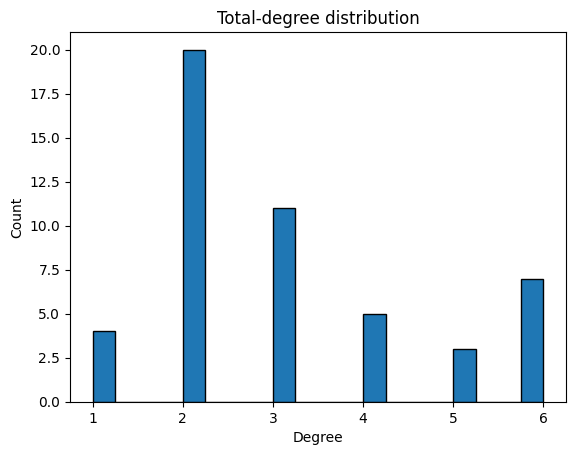

In [190]:
# --- 1. Basic stats
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G_directed.in_degree())
out_deg = dict(G_directed.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G_directed.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
plt.hist(list(tot_deg.values()), bins=20, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [191]:
html_file = "phase2.html" 
notebook: bool = True
colour_scheme: str = "layer" 
node_size_scale: float = 2.0
coord_scale: float = 1000.0

try:
    from pyvis.network import Network
except ImportError:
    raise ImportError("pyvis not found - install with `pip install pyvis`")

net = Network(height="750px", width="100%", directed=True,
            notebook=notebook, bgcolor="#ffffff", cdn_resources='remote')
net.repulsion()

# Compute each node's total degree
deg_in  = dict(G_directed.in_degree())
deg_out = dict(G_directed.out_degree())
total_deg = {n: deg_in.get(n, 0) + deg_out.get(n, 0) for n in G_directed.nodes}

# -------- nodes (with colours, tooltips, and dynamic sizes) ----------
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for n in G_directed.nodes:
    # Build hover title
    title = (
        f"Neuron {n}<br/>"
        f"InDegree: {deg_in.get(n, 0)}<br/>OutDegree: {deg_out.get(n, 0)}"
        f" Type: {G_directed.nodes[n].get('type', 'unknown')}<br/>"
    )

    # Size = (total_degree + 1) * node_size_scale
    size = (total_deg.get(n, 0) + 1) * node_size_scale

    net.add_node(n,
                label=str(n),
                title=title,
                size=size,
                # NOTE: coords[n] is a 3D coordinate, we use only x and z for 2D visualization
                x=coords[n][0] * coord_scale,  # Scale coords to fit in the network view
                y=coords[n][2] * coord_scale,
                fixed = True)  # Scale coords to fit in the network view)


# -------- edges ------------
for u, v, data in G_directed.edges(data=True):
    w = data.get("weight", None)
    syn_idx = data.get("synapse_index", None)
    dist = data.get("distance", None) * coord_scale  # anatomical distance
    # If distance is missing or zero, fallback to a small positive default
    length = float(dist) if (dist is not None and dist > 0.0) else 50.0

    # Edge thickness ∝ |weight|
    thickness = abs(w) if w is not None else 1.0

    hover_txt = []
    if syn_idx is not None:
        hover_txt.append(f"synapse_index = {syn_idx}")
    if w is not None:
        hover_txt.append(f"weight = {w:.3f}")
    if dist is not None:
        hover_txt.append(f"distance = {dist:.2f}")

    net.add_edge(
        u,
        v,
        value   = thickness * 0.1,         # edge thickness ∝ |weight|
        title   = "<br/>".join(hover_txt),
        # length  = length * 20              # rest‐length ≈ anatomical distance
    )

net.show(html_file)

phase2.html
